In [13]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Harris-Stephens Corner Detection

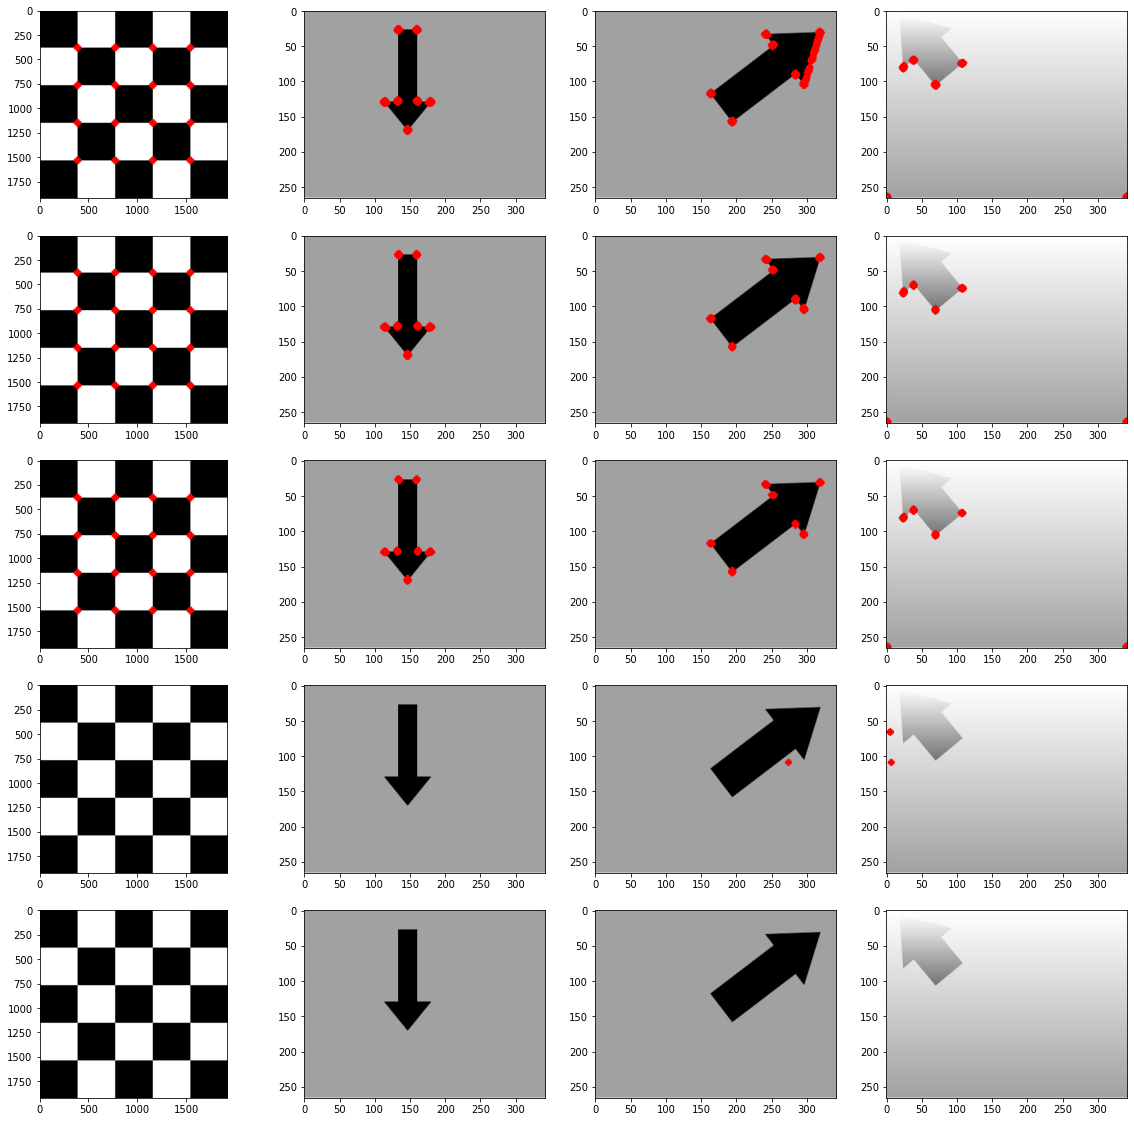

In [2]:
def draw_corners(img_path, k):
    Im = cv2.imread(f'./images/{img_path}', cv2.IMREAD_GRAYSCALE)
    corners = cv2.cornerHarris(Im, blockSize=3, ksize=3, k=k)
    marked = cv2.cvtColor(Im, cv2.COLOR_GRAY2RGB)
    max_val = 0.01*corners.max()
    scaled_size = Im.shape[0]//50

    for i, y in enumerate(corners):
        for j, x in enumerate(y):
            if x > max_val:
                marked = cv2.drawMarker(marked, (j, i), color=(255,0,0), markerType=cv2.MARKER_CROSS, markerSize=scaled_size, thickness=scaled_size)
                
    plt.imshow(marked)

paths = ['chessboard.png', 'arrow_1.jpg', 'arrow_2.jpg', 'arrow_3.jpg']
k_vals = [0.001, 0.04, 0.1, 0.25, 0.3]

plt.figure(figsize=(20,20))

for i, path in enumerate(paths):
    for j, k in enumerate(k_vals):
        plt.subplot(5, 4, (j*4)+i+1)
        draw_corners(path, k)

plt.show()

# SIFT Feature Detection

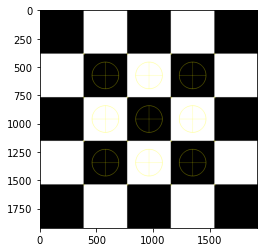

In [2]:
img = cv2.imread('images/chessboard.png', cv2.IMREAD_GRAYSCALE)

sift = cv2.xfeatures2d.SIFT_create()

kp = sift.detect(img, None)

out_img = cv2.drawKeypoints(img, kp, None, (255, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(out_img)

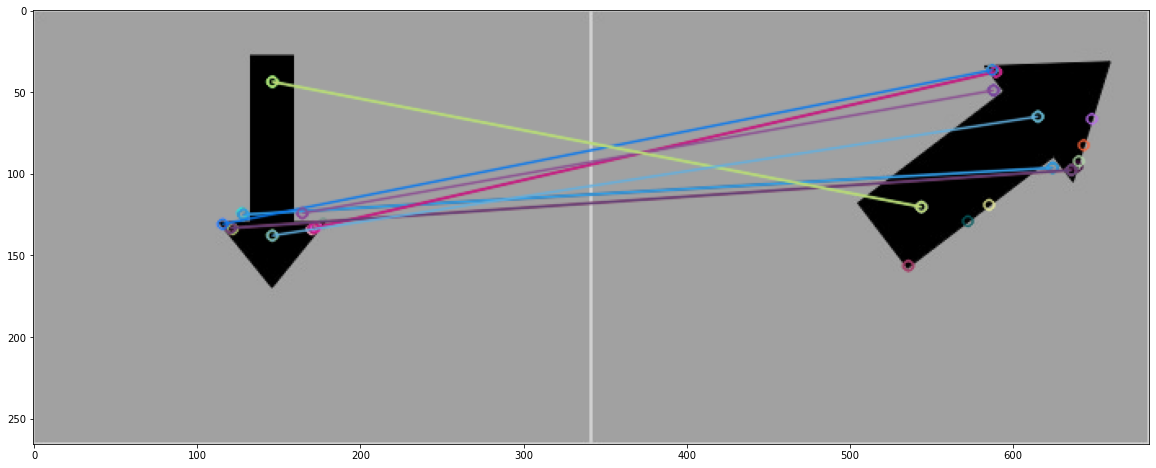

In [3]:
arrow1 = cv2.imread('images/arrow_1.jpg', cv2.IMREAD_GRAYSCALE)
arrow2 = cv2.imread('images/arrow_2.jpg', cv2.IMREAD_GRAYSCALE)

sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(arrow1, None)
kp2, des2 = sift.detectAndCompute(arrow2, None)

# initialize Brute force matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(des1,des2)

#sort the matches 
matches = sorted(matches, key= lambda match : match.distance)

matched_img = cv2.drawMatches(arrow1, kp1, arrow2, kp2, matches[:30], None) 

plt.figure(figsize=(20,20))
plt.imshow(matched_img)

In [22]:
# Create SIFT detector object
sift = cv2.xfeatures2d.SIFT_create()
# Define parameters for our Flann Matcher
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
search_params = dict(checks = 100)

def sift_detector(new_image, image_template, template_descriptor):
    # Function that compares input image to template
    # It then returns the number of SIFT matches between them
    image1 = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

    # Obtain the descriptors using SIFT
    _, descriptors_1 = sift.detectAndCompute(image1, None)

    # Create the Flann Matcher object
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Obtain matches using K-Nearest Neighbor Method
    # the result 'matchs' is the number of similar matches found in both images
    matches = flann.knnMatch(descriptors_1, template_descriptor, k=2)

    # Store good matches using Lowe's ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m) 

    return len(good_matches)

cap = cv2.VideoCapture(0)

# Reference image templates
images = [[cv2.imread(f'sift_images/{img}', 0), img] for img in os.listdir('sift_images')]

# Add descriptors to reference images
for img in images:
    _, descriptor = sift.detectAndCompute(img[0], None)
    img.append(descriptor)

# Get webcam images
ret, frame = cap.read()

# Get height and width of webcam frame
height, width = frame.shape[:2]

# Define ROI Box Dimensions
top_left_x = int (width / 3)
top_left_y = int ((height / 2) + (height / 4))
bottom_right_x = int ((width / 3) * 2)
bottom_right_y = int ((height / 2) - (height / 4))

# Our threshold to indicate object deteciton
# We use 10 since the SIFT detector returns little false positves
threshold = 10

while True:
    # Get webcam images
    ret, frame = cap.read()

    # Draw rectangular window for our region of interest   
    cv2.rectangle(frame, (top_left_x,top_left_y), (bottom_right_x,bottom_right_y), 255, 3)

    # Crop window of observation we defined above
    cropped = frame[bottom_right_y:top_left_y , top_left_x:bottom_right_x]

    # Flip frame orientation horizontally
    frame = cv2.flip(frame,1)

    for img in images:
        # Get number of SIFT matches
        matches = sift_detector(cropped, img[0], img[2])

        # # Display status string showing the current no. of matches 
        # cv2.putText(frame,str(matches),(450,450), cv2.FONT_HERSHEY_COMPLEX, 2,(0,255,0),1)

        if matches > threshold:
            cv2.rectangle(frame, (top_left_x,top_left_y), (bottom_right_x,bottom_right_y), (0,255,0), 3)
            cv2.putText(frame,img[1],(50,50), cv2.FONT_HERSHEY_COMPLEX, 2,(0,255,0),1)

    cv2.imshow('Object Detector using SIFT', frame)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break

cap.release()
cv2.destroyAllWindows()